In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install plotly_express

## Goal
The goal of this notebook is essentially to recommend a driver's lifetime value (LTV). 

In [0]:
import os

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/lyft'
os.chdir(PATH)

DATA_DIR = os.path.join(PATH, 'data')

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly_express as px

import umap

from datetime import datetime

import warnings
warnings.simplefilter(action='ignore')

## Read in

In [0]:
ride_timestamps = pd.read_csv(os.path.join(DATA_DIR, 'ride_timestamps.csv'))
ride_ids = pd.read_csv(os.path.join(DATA_DIR, 'ride_ids.csv'))
driver_ids = pd.read_csv(os.path.join(DATA_DIR, 'driver_ids.csv'))

In [6]:
ride_timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [7]:
ride_ids.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [8]:
driver_ids.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


## EDA

### `drivers_ids`

In [9]:
driver_ids['driver_id'].nunique() # len(driver_ids)

937

In [10]:
driver_ids['driver_onboard_date'].min(), driver_ids['driver_onboard_date'].max()

('2016-03-28 00:00:00', '2016-05-15 00:00:00')

The file `driver_ids.csv` consists of drivers who signed up as a driver with Lyft between 2016/03/28 to 2016/05/15.

### `ride_timestamps`

Check whether do the rides start after all the drivers have registered.

In [0]:
# convert timestamp to datetime object
ride_timestamps['timestamp'] = pd.to_datetime(ride_timestamps['timestamp'])

In [12]:
ride_timestamps['timestamp'].min(), ride_timestamps['timestamp'].max()

(Timestamp('2016-03-28 05:48:18'), Timestamp('2016-06-27 00:50:50'))

The dataset for rides started on 2016/03/28 and ended on 2016/06/27. We proceed to perform feature engineering on the `timestamp` of each ride.

In [0]:
# Feature engineer time features
def add_datepart(df, fldname, drop=False, time=True):
    """
    Taken from fast.ai
    Helper function that adds columns relevant to a date.
    """
    import re 
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    if time: attr = attr + ['Hour', 'Minute']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [14]:
add_datepart(ride_timestamps, 'timestamp')

ride_timestamps.head()

,ride_id,event,timestamp,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampHour,timestampMinute,timestampElapsed
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19,6.0,24.0,13.0,0.0,165.0,9.0,39.0,1465810759
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51,6.0,24.0,13.0,0.0,165.0,9.0,39.0,1465810791
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31,6.0,24.0,13.0,0.0,165.0,9.0,44.0,1465811071
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33,6.0,24.0,13.0,0.0,165.0,9.0,44.0,1465811073
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05,6.0,24.0,13.0,0.0,165.0,10.0,3.0,1465812185


One of the features we deem important later to perform segmenting on drivers is how long does a driver take, on average, to accept a ride. To do so, we have to calculate the time lag between a ride was requested `event == 'requested_at'` to the time the driver accepted the ride `event == 'accepted_at'`.

We hypothesize that keen drivers who are more likely to have a short window between those two events. We call this new feature `pickup_window`.

In [0]:
# calculate time lag wrt to `requested_at`
def seconds_lag(t):
    delta_to_t0 = t - t.iloc[0]
    return delta_to_t0

In [16]:
%%time
ride_timestamps['pickup_window'] = ride_timestamps.groupby('ride_id')['timestamp'].apply(seconds_lag)

ride_timestamps['pickup_window'] = ride_timestamps['pickup_window'].apply(lambda o: o.total_seconds())

CPU times: user 2min 5s, sys: 4.21 s, total: 2min 9s
Wall time: 2min 5s


In [17]:
ride_timestamps.head()

,ride_id,event,timestamp,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampHour,timestampMinute,timestampElapsed,pickup_window
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19,6.0,24.0,13.0,0.0,165.0,9.0,39.0,1465810759,0.0
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51,6.0,24.0,13.0,0.0,165.0,9.0,39.0,1465810791,32.0
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31,6.0,24.0,13.0,0.0,165.0,9.0,44.0,1465811071,312.0
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33,6.0,24.0,13.0,0.0,165.0,9.0,44.0,1465811073,314.0
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05,6.0,24.0,13.0,0.0,165.0,10.0,3.0,1465812185,1426.0


In [18]:
accepted_filter = ride_timestamps[ride_timestamps['event'] == 'accepted_at']

driver_accepted_filter = pd.merge(accepted_filter, ride_ids,
                                  on='ride_id')

window_g = driver_accepted_filter.groupby('driver_id')['pickup_window'].mean()

window_g = window_g.reset_index()

window_g.head()

,driver_id,pickup_window
0,002be0ffdc997bd5c50703158b7c2491,8.407942
1,007f0389f9c7b03ef97098422f902e62,11.838710
2,011e5c5dfc5c2c92501b8b24d47509bc,7.294118
3,0152a2f305e71d26cc964f8d4411add9,14.198953
4,01674381af7edd264113d4e6ed55ecda,12.528000


In [19]:
len(window_g)

844

In [20]:
ride_ids['driver_id'].nunique()

937

In [21]:
d = pd.merge(ride_ids, ride_timestamps, on='ride_id', how='inner')

d['driver_id'].nunique()

# d[d['driver_id'].isna()]['ride_id']

844

There are 93 drivers in `ride_ids` who do not have records in `ride_timestamps`.

## `ride_ids`
We would like to get an idea of how many rides has a driver completed over the course of the dataset. We call this feature `ride_count`. It will also be a crucial variable to calculate LTV later.

In [22]:
ride_id_g = ride_ids.groupby('driver_id')['ride_id'].count()

ride_id_g = ride_id_g.reset_index()

ride_id_g.rename(columns={'ride_id': 'ride_count'}, inplace=True)

ride_id_g.sort_values(by='ride_count', ascending=False).head()

,driver_id,ride_count
354,5ccc0e6dc9c7475caf785cdce7b8eb7a,919
308,4eb382d1f7d50fae1294964263d1ce82,831
509,844e9be5a30d8d9c1f8e9ddb086ff717,821
401,689bdf87fb2de49f98bf4946cfaa5068,794
217,3788dc9e91f1548816ce8b5af07ddadc,783


In [23]:
driver_ids['driver_id'].nunique(), ride_ids['driver_id'].nunique()

(937, 937)

In [24]:
len(set(driver_ids['driver_id'].unique().tolist()).intersection(set(ride_ids['driver_id'].unique().tolist())))

854

In [25]:
ride_ids.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [26]:
len(driver_ids[~driver_ids['driver_id'].isin(ride_ids['driver_id'].unique())])

83

Interestingly, even we have 937 unique `driver_id`s for both `driver_ids` and `ride_ids`, only 854 overlap. That means, 83 drivers that appear in ride_ids do not have any record in `driver_ids`.

In [27]:
ride_timestamps['ride_id'].nunique(), ride_ids['ride_id'].nunique()

(194081, 193502)

In [28]:
len(set(ride_timestamps['ride_id'].unique().tolist()).intersection(set(ride_ids['ride_id'].unique().tolist())))

184819

Only 184,819 unique `ride_id`s exist in `ride_timestamps` and `ride_ids`.

To calculate the fare, we first convert the `ride_distance` from metres to mile and convert the `ride_duration` from seconds to minutes.

In [0]:
ride_ids['ride_distance'] = ride_ids['ride_distance'] / 1609.34

ride_ids['ride_duration'] = ride_ids['ride_duration'] / 60

To calculate the fare, we employed the assumptions about the Lyft rate card in the prompt. The formula we use is as follows:

(2 + 1.15 * total distance traveled + 0.22 * total time traveled) * (1 + (prime time / 100)) + 1.75

After calculating the fare, we limited the lower bound of the fare to 5 USD and the upper of the fare to 400 USD.

In [30]:
ride_ids['fare'] = (2 + 
                     ride_ids['ride_distance'] * 1.15 + 
                     ride_ids['ride_duration'] * 0.22) * \
                    ((ride_ids['ride_prime_time'] + 100) / 100) \
                    + 1.75 

ride_ids['fare'].describe()

def limit_bound(fare):
    return min(max(5, fare), 400)

ride_ids['fare'] = ride_ids['fare'].apply(limit_bound)

ride_ids['fare'].describe()

count    193502.000000
mean         13.536544
std           9.881417
min           5.000000
25%           8.036033
50%          10.571234
75%          15.115603
max         400.000000
Name: fare, dtype: float64

In [31]:
fare_g = ride_ids.groupby('driver_id')['fare'].sum()

fare_g = fare_g.reset_index()

fare_g.sort_values(by='fare', ascending=False).head()

,driver_id,fare
354,5ccc0e6dc9c7475caf785cdce7b8eb7a,12350.288077
217,3788dc9e91f1548816ce8b5af07ddadc,12304.887351
308,4eb382d1f7d50fae1294964263d1ce82,10781.942344
412,6b65c06851e944351dd285a1eb729499,10708.943770
509,844e9be5a30d8d9c1f8e9ddb086ff717,10613.901682


We then calculated the sum of the fare for each driver. This will be the total income generated by the driver.

The higher a driver's `ride_prime_time`, the more her or she is valuable to Lyft since they help to meet passengers' demand. This could be another important feature for segmenting drivers. Since we are only interested in the mean of the nonzero `ride_prime_time` values and we do not want 0 values to distort the `ride_prime_time` lower, we replace all zeros with `NaN`.

In [32]:
# make the variable NaN to calculate mean
ride_ids['ride_prime_time'].replace(0, np.nan, inplace=True)

ride_prime_time_g = ride_ids.groupby('driver_id')['ride_prime_time'].mean()

ride_prime_time_g = ride_prime_time_g.reset_index()

ride_prime_time_g.sort_values(by='ride_prime_time', ascending=False).head()

,driver_id,ride_prime_time
807,dae249fc394c9bdf02f7d8bb1ff55733,146.875000
676,b2d3f2fb171a12cac427107690c10089,105.000000
420,6cb35e276085548f3f095a85aa63af7b,98.076923
443,7419cd5c573ff9994c0f8ff5d92b4408,91.071429
655,acd7dc6118befb6724aa3752d1cdbea1,90.277778


In [0]:
# change back to original value
ride_prime_time_g['ride_prime_time'].fillna(0, inplace=True)

Merge both `driver_ids` and `driver_timestamps`.

In [34]:
ids_timestamps = pd.merge(ride_ids, ride_timestamps,
                          left_on='ride_id',
                          right_on='ride_id',
                          how='outer')

ids_timestamps = ids_timestamps.sort_values(by=['driver_id', 'timestamp'])

ids_timestamps.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,fare,event,timestamp,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampHour,timestampMinute,timestampElapsed,pickup_window
1235,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,requested_at,2016-03-29 18:46:50,3.0,13.0,29.0,1.0,89.0,18.0,46.0,1.459277e+09,0.0
1236,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,accepted_at,2016-03-29 18:47:01,3.0,13.0,29.0,1.0,89.0,18.0,47.0,1.459277e+09,11.0
1237,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,arrived_at,2016-03-29 18:50:00,3.0,13.0,29.0,1.0,89.0,18.0,50.0,1.459277e+09,190.0
1238,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,picked_up_at,2016-03-29 18:50:01,3.0,13.0,29.0,1.0,89.0,18.0,50.0,1.459277e+09,191.0
1239,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,dropped_off_at,2016-03-29 18:55:47,3.0,13.0,29.0,1.0,89.0,18.0,55.0,1.459278e+09,537.0


Since part-time drivers should have a lower LTV compared to full-time drivers, we hypothesize that drivers who drive mainly on weekends are part-time drivers.

In [35]:
# Monday 0, Sunday 6
ids_timestamps['is_weekday'] = 0 
ids_timestamps.loc[ids_timestamps['timestampDayofweek'] < 5, 'is_weekday'] = 1

weekday_drivers_g = ids_timestamps.groupby('driver_id')['is_weekday'].mean()

weekday_drivers_g = weekday_drivers_g.reset_index()

weekday_drivers_g.sort_values(by='is_weekday').head()

,driver_id,is_weekday
870,ea71f79a86672486e018deeb47a545ec,0.0
296,4bbf15c7280e29c1df6edd7bf6dfa56a,0.0
108,1cf6fa07dcec364af2acf257b2d3731e,0.0
732,c64e642876910be4a1f0b57404dc9710,0.0
210,364c929f1d6535aa17df83ebcb349e87,0.0


In [36]:
ids_timestamps[ids_timestamps['driver_id'] == 'ea71f79a86672486e018deeb47a545ec']['ride_id'].nunique()

72

Driver `ea71f79a86672486e018deeb47a545ec` made 72 rides in the entire dataset and all rides only happen on weekends.

Next, we look into drivers who prefer to drive in the morning v.s. drivers who prefer to drive at night. We define `is_late_ride` as rides that happen between 11:00 PM and 6:00 AM.

In [37]:
ids_timestamps['is_late_ride'] = 0 
ids_timestamps.loc[(ids_timestamps['timestampHour'] >= 23) |
                   (ids_timestamps['timestampHour'] <= 6), 
                   'is_late_ride'] = 1

is_late_ride_g = ids_timestamps.groupby('driver_id')['is_late_ride'].mean()

is_late_ride_g = is_late_ride_g.reset_index()

is_late_ride_g.sort_values(by='is_late_ride', ascending=False).head()

,driver_id,is_late_ride
523,8969d175c4676642b245af55d2dba19b,0.903448
222,3857da988688981b67c878fc179eb0dc,0.898947
551,905f8007cd46415eba8b9dce088b4395,0.891892
466,793e2072826ee96904a5f03ae2357e96,0.873927
77,175540c364f94b6adbc0ce3541a3254a,0.870370


In [38]:
ids_timestamps[ids_timestamps['driver_id'] == '3857da988688981b67c878fc179eb0dc']['ride_id'].nunique()

190

Driver `3857da988688981b67c878fc179eb0dc` completed 190 rides in the entire dataset and on most of the rides are completed at night.

Next, we create a feature `drop_requested_lag` to measure how fast do drivers pick up the next ride after they drop off passengers. The feature `drop_requested_lag` only considers same day pickups. So there exists a condition that a driver only picks up a passenger a day and this might lead to low `drop_requested_lag` value.

In [39]:
# shift the timestamp down 1 row
# and subtract the timestamp_shift from timestamp
# to measure the lag between a dropoff and request time
# since most request time is relatively close to pickup time
# this can be a good proxy
ids_timestamps['timestamp_shift'] = ids_timestamps.groupby('driver_id')['timestamp'].apply(lambda o: o.shift())

ids_timestamps['delta_timestamp'] = ids_timestamps['timestamp'] - ids_timestamps['timestamp_shift']

ids_timestamps.head(8)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,fare,event,timestamp,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampHour,timestampMinute,timestampElapsed,pickup_window,is_weekday,is_late_ride,timestamp_shift,delta_timestamp
1235,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,requested_at,2016-03-29 18:46:50,3.0,13.0,29.0,1.0,89.0,18.0,46.0,1.459277e+09,0.0,1,0,NaT,NaT
1236,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,accepted_at,2016-03-29 18:47:01,3.0,13.0,29.0,1.0,89.0,18.0,47.0,1.459277e+09,11.0,1,0,2016-03-29 18:46:50,00:00:11
1237,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,arrived_at,2016-03-29 18:50:00,3.0,13.0,29.0,1.0,89.0,18.0,50.0,1.459277e+09,190.0,1,0,2016-03-29 18:47:01,00:02:59
1238,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,picked_up_at,2016-03-29 18:50:01,3.0,13.0,29.0,1.0,89.0,18.0,50.0,1.459277e+09,191.0,1,0,2016-03-29 18:50:00,00:00:01
1239,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,1.541004,5.766667,NaN,6.790822,dropped_off_at,2016-03-29 18:55:47,3.0,13.0,29.0,1.0,89.0,18.0,55.0,1.459278e+09,537.0,1,0,2016-03-29 18:50:01,00:05:46
5,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089055,13.483333,NaN,9.118747,requested_at,2016-03-29 19:00:49,3.0,13.0,29.0,1.0,89.0,19.0,0.0,1.459278e+09,0.0,1,0,2016-03-29 18:55:47,00:05:02
6,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089055,13.483333,NaN,9.118747,accepted_at,2016-03-29 19:00:52,3.0,13.0,29.0,1.0,89.0,19.0,0.0,1.459278e+09,3.0,1,0,2016-03-29 19:00:49,00:00:03
7,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089055,13.483333,NaN,9.118747,arrived_at,2016-03-29 19:03:57,3.0,13.0,29.0,1.0,89.0,19.0,3.0,1.459278e+09,188.0,1,0,2016-03-29 19:00:52,00:03:05


In [0]:
ids_timestamps.loc[(ids_timestamps['event'] == 'requested_at') &
                   (~ids_timestamps['delta_timestamp'].isna()), 'drop_requested_lag'] = 1

ids_timestamps['drop_requested_lag'].fillna(0, inplace=True)

ids_timestamps['drop_requested_lag'] = ids_timestamps['drop_requested_lag'] * ids_timestamps['delta_timestamp']

ids_timestamps['drop_requested_lag'] = ids_timestamps['drop_requested_lag'].apply(lambda o: o.total_seconds())

ids_timestamps.loc[ids_timestamps['delta_timestamp'].dt.days > 0, 'drop_requested_lag'] = np.nan

In [41]:
filtered_requested_at = ids_timestamps[ids_timestamps['event'] == 'requested_at']

drop_requested_lag_g = filtered_requested_at.groupby('driver_id')['drop_requested_lag'].mean()

drop_requested_lag_g = drop_requested_lag_g.reset_index()

drop_requested_lag_g.sort_values(by='drop_requested_lag').head()

,driver_id,drop_requested_lag
441,7ff85c5c0e9324e28d1e0d0589c364bd,181.000000
526,9a54684a69721c1075c2af5fc077665b,754.351351
495,905f8007cd46415eba8b9dce088b4395,936.774194
226,42256e33936dfa69088f540a720edc97,942.870968
313,5cf93f7d1d3a8f0cf395c84053c31b1b,976.818182


Merge `ids_timestamps` with `driver_id`.

In [0]:
df = pd.merge(ids_timestamps, driver_ids,
              left_on='driver_id', right_on='driver_id')

To calculate how many actual days did the driver drive, we calculate the number of unique days the driver has activity.

In [43]:
df['date'] = df['timestamp'].dt.date

unique_dates_g = df.groupby('driver_id')['date'].nunique()

unique_dates_g = unique_dates_g.reset_index()

unique_dates_g.rename(columns={'date': 'unique_days'}, inplace=True)

unique_dates_g.head()

,driver_id,unique_days
0,002be0ffdc997bd5c50703158b7c2491,56
1,007f0389f9c7b03ef97098422f902e62,12
2,011e5c5dfc5c2c92501b8b24d47509bc,12
3,0152a2f305e71d26cc964f8d4411add9,42
4,01674381af7edd264113d4e6ed55ecda,40


Next, we create the feature `driving_period` to account for the duration between the last trip a driver made and the day the driver was onboard. 

In [0]:
df['driving_period'] = (df.groupby('driver_id')['timestamp'].tail(1) - pd.to_datetime(df['driver_onboard_date'])).dt.days

To calculate the average churn rate, we first get the driver's last activity based on `timestamp` in `ride_timestamps`. Since the last day of the `timestamp` in `ride_timestamps` was 2016/06/27, we calculate the number of days since the driver's last activity with respect to the last day of the dataset. We assume drivers who have more than 7 days of inactivity have churned.

In [0]:
df['last_activity'] = (df['timestamp'].max() - df.groupby('driver_id')['timestamp'].tail(1)).dt.days

last_activity_df = df.groupby('driver_id').tail(1)

In [46]:
len(last_activity_df[last_activity_df['last_activity'] > 7]), len(last_activity_df)

(305, 854)

In [47]:
t = pd.merge(ids_timestamps, driver_ids,
              left_on='driver_id', right_on='driver_id', how='outer')

t[t['driver_id'].isna()]['ride_id'].nunique()

9262

There are 305 drivers whose last activity was more than 7 days. Meanwhile, for the 83 drivers who have no record in `ride_timestamps`, all of them together completed 9,262 trips. We assume that they have not churned.

In [48]:
churn_rate = len(last_activity_df[last_activity_df['last_activity'] > 7]) / len(last_activity_df)

churn_rate

0.35714285714285715

We proceed to create a bar plot of number of active drivers.

In [0]:
first_day = ids_timestamps.groupby('driver_id')['timestamp'].min().reset_index()
first_day.rename(columns={'timestamp': 'first_day'}, inplace=True)

last_day = ids_timestamps.groupby('driver_id')['timestamp'].max().reset_index()
last_day.rename(columns={'timestamp': 'last_day'}, inplace=True)

first_last_day = pd.merge(first_day, last_day, on='driver_id')

first_last_day.loc[((df['timestamp'].max() - first_last_day['last_day']).dt.days <= 7),
                   'last_day'] = df['timestamp'].max()

In [50]:
first_last_day.head()

,driver_id,first_day,last_day
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 18:46:50,2016-06-27 00:50:50
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 22:28:28,2016-06-27 00:50:50
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 10:54:51,2016-06-12 20:30:38
3,0152a2f305e71d26cc964f8d4411add9,2016-04-25 15:59:20,2016-06-27 00:50:50
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 07:50:40,2016-06-27 00:50:50


In [0]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

date_count = {}
for day in daterange(first_last_day['first_day'].min(), first_last_day['last_day'].max()):
    between = first_last_day[(first_last_day['first_day'] <= day) & (first_last_day['last_day'] >= day)]
    date_count[day] = len(between)

In [52]:
retention = pd.DataFrame(date_count.items())

retention.rename(columns={0: 'date',
                          1: 'num_drivers_onboard'}, inplace=True)

retention['date'] = retention['date'].apply(lambda o: o.strftime('%m-%d'))

retention.head()

,date,num_drivers_onboard
0,03-28,1
1,03-29,21
2,03-30,48
3,03-31,70
4,04-01,92


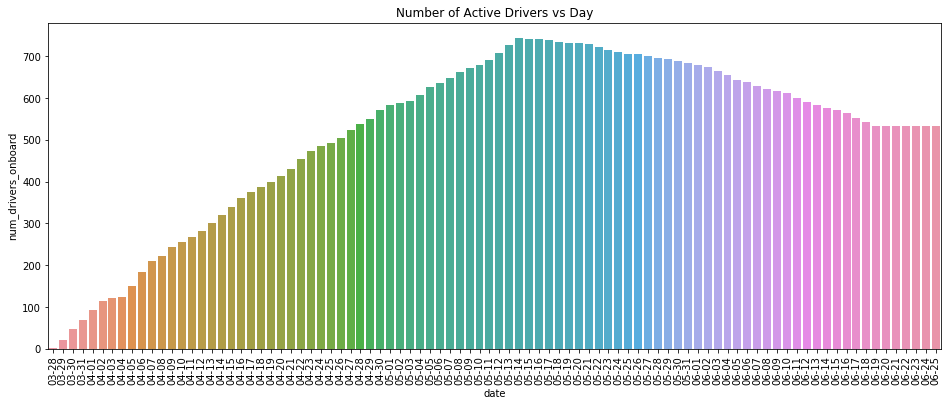

In [53]:
plt.figure(figsize=(16,6))
plt.title('Number of Active Drivers vs Day')
sns.barplot(x=retention['date'],
            y=retention['num_drivers_onboard'])
plt.xticks(rotation=90)
plt.show()

The graph flattens out because we assumed drivers who have less than 7 days of inactivity have not churned, but rather, are taking a break.

Since having days on the x-axis would be too compact, we also create a plot with week on the x-axis.

In [0]:
N = 7
weekly_retention = retention.groupby(retention.index // N).mean()

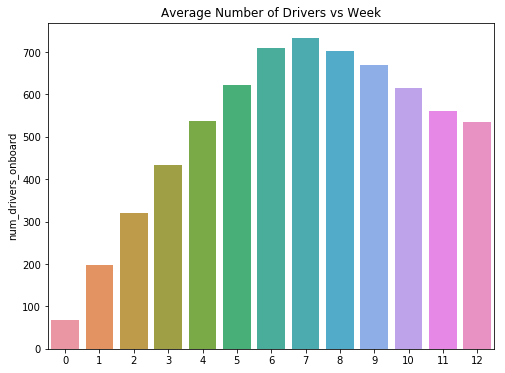

In [55]:
plt.figure(figsize=(8,6))
plt.title('Average Number of Drivers vs Week')
sns.barplot(x=np.arange(len(weekly_retention)),
            y=weekly_retention['num_drivers_onboard'])
plt.show()

In [56]:
onboard_period = df[~df['driving_period'].isna()]

onboard_period = onboard_period[['driver_id', 'driving_period']].copy()

onboard_period.sort_values('driving_period').head()

,driver_id,driving_period
715947,bd057e02f75c92917389d90bb215fe91,1.0
404840,68b546b2f4102641d6774c1ce4f57457,1.0
429430,6eb2e0f41fc9f1fbb70e7751035fdf87,1.0
609573,a2334fdb829cf96fbae920df0cce1587,2.0
841116,e4f3a9d5cf57b9b518136afd9757f76d,3.0


## LTV
We next calculate the LTV for drivers.

In [0]:
ltv = ride_id_g

to_merge = (drop_requested_lag_g, ride_prime_time_g, fare_g, 
            onboard_period, window_g, unique_dates_g,
            weekday_drivers_g, is_late_ride_g)

for ser in to_merge:
    ltv = pd.merge(ltv, ser, on='driver_id', how='outer')

In [58]:
ltv.isna().sum()

driver_id               0
ride_count              0
drop_requested_lag     94
ride_prime_time         0
fare                    0
driving_period        101
pickup_window          93
unique_days            83
is_weekday              0
is_late_ride            0
dtype: int64

It is hard to decide a driver's `drop_requested_lag` if he or she does not have any record of ride in `ride_timestamps`. Hence, we decide to impute the `drop_requested_lag`'s `NaN`s as the mean of all `drop_requested_lag`. Same goes for all features that require entries in `ride_timestamps` for calculation.

In [0]:
ltv['driving_period'].fillna(ltv['driving_period'], inplace=True)

ltv['drop_requested_lag'].fillna(ltv['drop_requested_lag'], inplace=True)

ltv['pickup_window'].fillna(ltv['pickup_window'], inplace=True)

ltv['unique_days'].fillna(ltv['unique_days'].mean(), inplace=True)
ltv['unique_days'].replace(0, ltv['unique_days'].mean(), inplace=True)

ltv['drop_requested_lag'].fillna(ltv['drop_requested_lag'].mean(), inplace=True)

ltv['driving_period'].fillna(ltv['driving_period'].mean(), inplace=True)

ltv['pickup_window'].fillna(ltv['pickup_window'].mean(), inplace=True)

In [60]:
ltv.head()

,driver_id,ride_count,drop_requested_lag,ride_prime_time,fare,driving_period,pickup_window,unique_days,is_weekday,is_late_ride
0,002be0ffdc997bd5c50703158b7c2491,277,6594.516129,48.863636,3560.926071,86.0,8.407942,56.0,0.769675,0.238989
1,007f0389f9c7b03ef97098422f902e62,31,4615.550000,52.083333,321.494948,85.0,11.838710,12.0,0.709677,0.000000
2,011e5c5dfc5c2c92501b8b24d47509bc,34,7185.041667,42.187500,482.428390,68.0,7.294118,12.0,0.529412,0.058824
3,0152a2f305e71d26cc964f8d4411add9,191,10028.796610,42.708333,2610.871561,64.0,14.198953,42.0,0.796859,0.459686
4,01674381af7edd264113d4e6ed55ecda,375,6633.404372,47.474747,5381.097539,56.0,12.528000,40.0,1.000000,0.054933


## Questions
* What are the main factors that affect a driver's lifetime value?
* What is the average projected lifetime of a driver? That is, once a driver is
onboarded, how long do they typically continue driving with Lyft?
* Do all drivers act alike? Are there specific segments of drivers that generate more
value for Lyft than the average driver?
* What actionable recommendations are there for the business?

In [0]:
# https://blog.hubspot.com/service/how-to-calculate-customer-lifetime-value
ltv['average_ride_val'] = ltv['fare'] / ltv['ride_count']

ltv['average_ride_freq'] = ltv['ride_count'] / ltv['unique_days']

ltv['average_val'] = ltv['average_ride_val'] * ltv['average_ride_freq']

ltv['ltv'] = ltv['average_val'] * 365 / churn_rate

In [62]:
base_metrics = ['ride_count', 'fare', 'unique_days', 'ltv']

ltv[['driver_id'] + base_metrics].sort_values(by='ltv', ascending=False).head()

,driver_id,ride_count,fare,unique_days,ltv
412,6b65c06851e944351dd285a1eb729499,718,10708.943770,45.0,243212.011849
217,3788dc9e91f1548816ce8b5af07ddadc,783,12304.887351,56.0,224564.194153
156,297e507cc9f1da096e51c2223657255b,588,8657.558363,40.0,221200.616165
318,51b528390e8e7780595f6009b1f4cf72,240,3018.980483,14.0,220385.575245
426,6eb2e0f41fc9f1fbb70e7751035fdf87,35,421.815299,2.0,215547.617792


The main factors that affect lifetime value (LTV) are the number of rides a driver has completed, `ride_count`, total revenue generated by the driver, `fare` and the number of days the driver worked, `unique_days`.

In [63]:
1 / churn_rate

2.8

We take average lifetime as the inverse of churn rate. Hence, we predict the average lifetime for drivers is approximately 2.8 years.

## KMeans Clustering
We performing KMeans Clustering to segment the drivers. Silhoutte score is then used to find the optimal K, in our case, where K=3 produces the best result. To test whether do our engineered features, such as `is_weekday`, `is_late_ride`, and others work later, we only fit KMeans to the `base_metrics`, which are `ride_count`, `fare`, `unique_days`, and `ltv`.

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [65]:
# only fit base_metrics for KMeans
lvt_matrix = ltv[base_metrics].values

CLUSTERS = 3

kmeans = KMeans(n_clusters=CLUSTERS, init='k-means++', n_init=40)
kmeans.fit(lvt_matrix)

clusters = kmeans.predict(lvt_matrix)

print("The average silhouette_score is: {:.4f}".format(silhouette_score(lvt_matrix, clusters)))

The average silhouette_score is: 0.5643


In [0]:
clusters_df = pd.Series(clusters).value_counts().reset_index()

clusters_df.rename(columns={'index': 'cluster', 0: 'count'}, inplace=True)

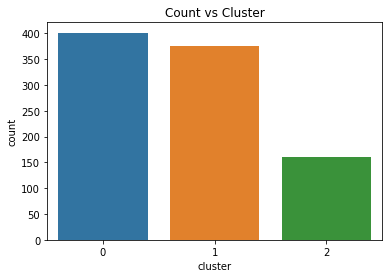

In [67]:
plt.figure(figsize=(6,4))
sns.barplot(x=clusters_df['cluster'], y=clusters_df['count'])
plt.title('Count vs Cluster')
plt.show()

To further perform an anlysis on the other features we created, we create a list of `metrics` as follows.

In [68]:
exclude = ['driver_id', 'ride_count', 'driving_period', 'average_val']
metrics = [col for col in ltv.columns if col not in exclude]

metrics

['drop_requested_lag',
 'ride_prime_time',
 'fare',
 'pickup_window',
 'unique_days',
 'is_weekday',
 'is_late_ride',
 'average_ride_val',
 'average_ride_freq',
 'ltv']

## Radar chart
The maximum value for each feature is calculated to scale our radar chart.

In [69]:
ltv['clusters'] = clusters

scale_max = ltv[metrics].max().values

scale_max

array([3.85809615e+04, 1.46875000e+02, 1.23502881e+04, 4.12500000e+01,
       8.10000000e+01, 1.00000000e+00, 9.03448276e-01, 2.59015036e+01,
       1.75000000e+01, 2.43212012e+05])

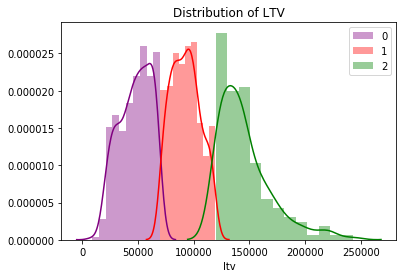

In [70]:
plt.title('Distribution of LTV')
# sns.distplot(ltv['ltv'])
fig = plt.subplot()
sns.distplot(ltv[ltv['clusters']==0]['ltv'],color ='purple')
sns.distplot(ltv[ltv['clusters']==1]['ltv'],color ='red')
sns.distplot(ltv[ltv['clusters']==2]['ltv'],color ='green')    
fig.legend(labels=['0','1', '2'])
plt.show()

In [0]:
def radar_cluster(i):
    radar = pd.DataFrame(ltv[ltv['clusters'] == i][metrics].mean()).reset_index()

    radar['r'] = radar.loc[:, 0] / scale_max

    radar.rename(columns={'index': 'theta'}, inplace=True)

    return radar

Plot the radar chart.

In [72]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=radar_cluster(0)['r'],
      theta=radar_cluster(0)['theta'],
      fill='toself',
      name='Cluster 0'
))
fig.add_trace(go.Scatterpolar(
      r=radar_cluster(1)['r'],
      theta=radar_cluster(1)['theta'],
      fill='toself',
      name='Cluster 1'
))
fig.add_trace(go.Scatterpolar(
      r=radar_cluster(2)['r'],
      theta=radar_cluster(2)['theta'],
      fill='toself',
      name='Cluster 2'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 0.8]
    )),
  showlegend=False,
  title='Segment of drivers'
)

fig.show()

From this radar chart, we observe that even we only fitted KMeans with the 4 base metrics: `ride_count`, `fare`, `unique_days`, and `ltv` to get 3 clusters, other feature such as `is_weekday` is fairly distinct for the clusters above. We then conclude that `is_weekday` might be a useful feature to help segmenting drivers.

## Other metrics
Showing that using `base_metrics` already allows other features to help us predict which segment a driver will fall into, we proceed to fit the `metrics` to the KMeans algorithm.

In [73]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_ltv = ltv.copy()

scaled_ltv[metrics] = scaler.fit_transform(ltv[metrics])

scaled_ltv.head()

,driver_id,ride_count,drop_requested_lag,ride_prime_time,fare,driving_period,pickup_window,unique_days,is_weekday,is_late_ride,average_ride_val,average_ride_freq,average_val,ltv,clusters
0,002be0ffdc997bd5c50703158b7c2491,277,0.167019,0.332689,0.286844,86.0,0.092900,0.683544,0.769675,0.264530,0.247527,0.239177,63.587966,0.239848,0
1,007f0389f9c7b03ef97098422f902e62,31,0.115483,0.354610,0.024001,85.0,0.187658,0.126582,0.709677,0.000000,0.104225,0.095960,26.791246,0.079453,0
2,011e5c5dfc5c2c92501b8b24d47509bc,34,0.182397,0.287234,0.037059,68.0,0.062136,0.126582,0.529412,0.065110,0.324454,0.111111,40.202366,0.137911,0
3,0152a2f305e71d26cc964f8d4411add9,191,0.256453,0.290780,0.209758,64.0,0.252848,0.506329,0.796859,0.508813,0.294486,0.215007,62.163609,0.233639,0
4,01674381af7edd264113d4e6ed55ecda,375,0.168032,0.323232,0.434530,56.0,0.206696,0.481013,1.000000,0.060804,0.333713,0.507576,134.527438,0.549070,2


In [74]:
CLUSTERS = 3

matrix = scaled_ltv[metrics].values

kmeans = KMeans(n_clusters=CLUSTERS, init='k-means++', n_init=40)
kmeans.fit(matrix)

clusters = kmeans.predict(matrix)

print("The average silhouette_score is: {:.4f}".format(silhouette_score(matrix, clusters)))

The average silhouette_score is: 0.3475


## Indexing
Credits to Françoise Provencher's talk at Montréal-Python 71.

In [75]:
scaled_ltv['all_feats_clusters'] = clusters

# map back to original clusters
scaled_ltv['all_feats_clusters'] = scaled_ltv['all_feats_clusters'].map({0: 1,
                                                                         1: 2, 
                                                                         2: 0})

indexed = scaled_ltv.groupby('all_feats_clusters').mean()

indexed = indexed[metrics].copy()

indexed

,drop_requested_lag,ride_prime_time,fare,pickup_window,unique_days,is_weekday,is_late_ride,average_ride_val,average_ride_freq,ltv
all_feats_clusters,,,,,,,,,,
0,0.190114,0.331381,0.374537,0.183542,0.544666,0.712459,0.187223,0.286181,0.411789,0.420008
1,0.195848,0.337646,0.087958,0.190502,0.300034,0.051257,0.077502,0.292403,0.146534,0.166936
2,0.243823,0.332564,0.050992,0.197340,0.136165,0.755016,0.152247,0.297674,0.197040,0.212036


In [0]:
for metric in metrics:
    indexed[metric] = indexed[metric] - scaled_ltv[metric].mean()
    indexed[metric] = indexed[metric] / indexed[metric].abs().max()

In [77]:
def coloring(val):
    if val < -0.5:
        color = '#d65f5f'
    elif val > 0.5:
        color = '#5fba7d'
    else:
        color = 'white'
    return 'background: %s' % color

table = indexed.T.style.applymap(coloring)

table

all_feats_clusters,0,1,2
drop_requested_lag,-0.562289,-0.39549,1
ride_prime_time,-0.246306,1,-0.0109757
fare,0.862204,-0.787238,-1
pickup_window,-0.702237,0.156404,1
unique_days,0.739236,-0.302311,-1
is_weekday,0.123698,-1,0.196024
is_late_ride,0.32024,-1,-0.100609
average_ride_val,-0.716548,0.212839,1
average_ride_freq,0.701498,-1,-0.676026
ltv,0.713795,-1,-0.694586


## Other visualizations

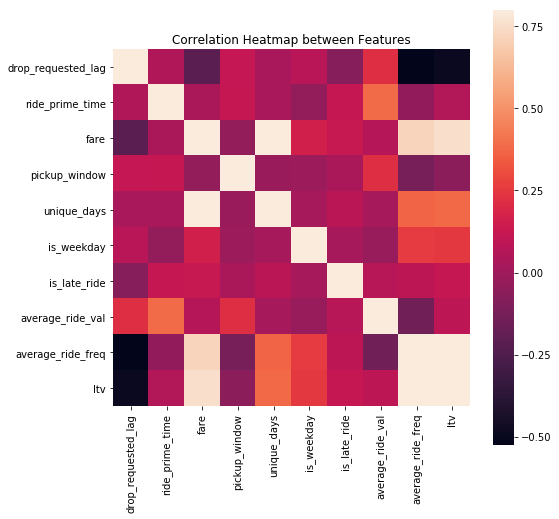

In [78]:
corr_mat = ltv[metrics].corr()

plt.figure(figsize=(8,8))
plt.title('Correlation Heatmap between Features')
sns.heatmap(corr_mat, vmax=.8, square=True);

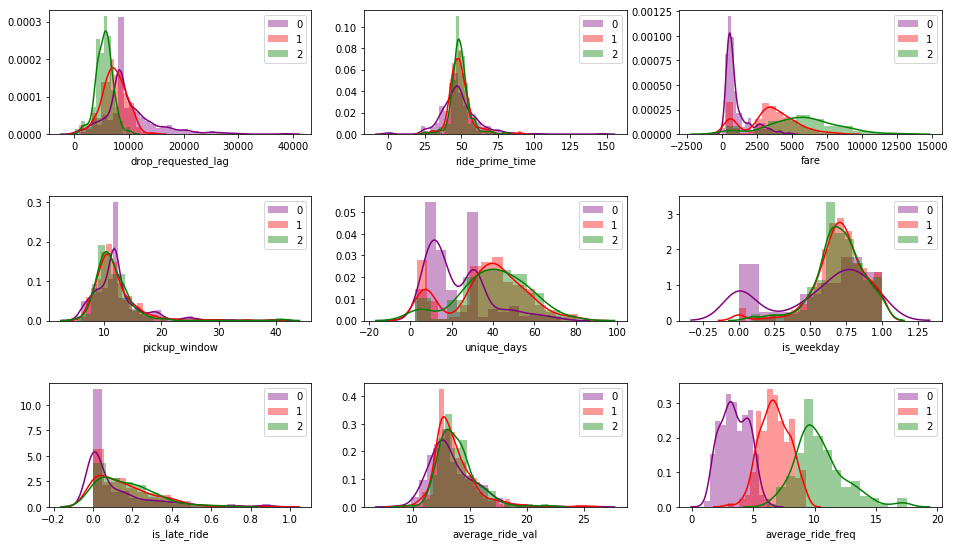

In [82]:
plt.figure(figsize=(16,40))
for i, m in enumerate(metrics[:-1]):
    fig = plt.subplot(12, 3, i+1)
    sns.distplot(ltv[ltv['clusters']==0][m],color ='purple')
    sns.distplot(ltv[ltv['clusters']==1][m],color ='red')
    sns.distplot(ltv[ltv['clusters']==2][m],color ='green')    
    plt.subplots_adjust(hspace=0.5)
    fig.legend(labels=[0,1,2])
plt.show()

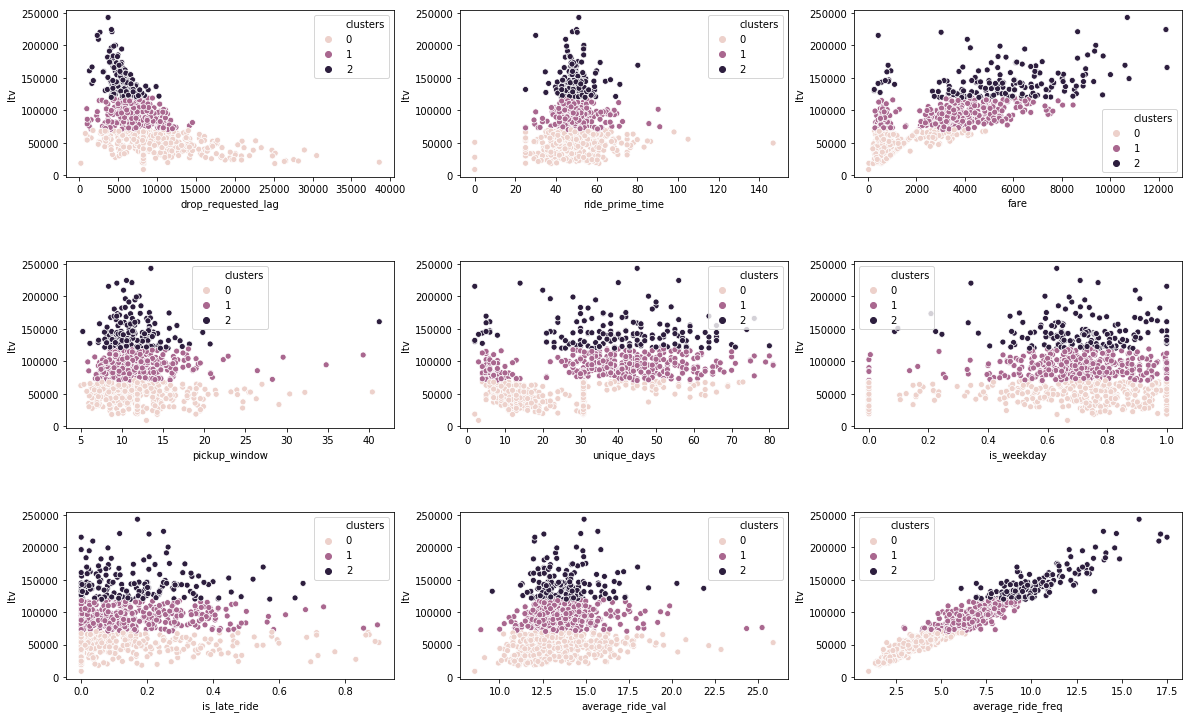

In [80]:
plt.figure(figsize=(20,40))
for i, m in enumerate(metrics[:-1]):
    plt.subplot(9, 3, i+1)
    sns.scatterplot(x=ltv[m], y=ltv[metrics[-1]],
                    hue=ltv['clusters'])
    plt.subplots_adjust(hspace=0.5)
    
plt.show()

## UMAP
We also attempted to perform UMAP on the metrices. It seems like we are able to separate each cluster out distinctly based in 2D projections.

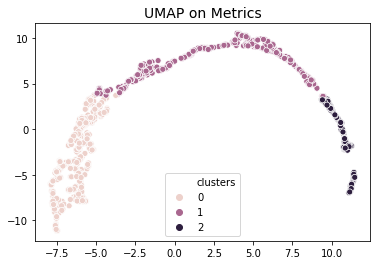

In [81]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(ltv[metrics])

plt.title('UMAP on Metrics', fontsize=14)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],
                hue=ltv['clusters'])
plt.show()